# ETAS MultiCatalog

We evaluate the model performance with 1000 synthetic ETAS-generated catalogs split into training (600), validation (200), and test (200) sets. Each catalog samples 10,000 days, containing around 103 events. We train and evaluate both the NTPP and ETAS model on the same set of synthetic ETAS-generated sequences. The design of this particular experiment implies that the ETAS model cannot be outperformed in the long-run. On its own synthetic data ETAS is, in expectation, an upper limit on a model joint-log likelihood.

In [1]:
import torch
import eq
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import string

from collections import defaultdict
from tqdm.auto import tqdm
from pathlib import Path

device = "cpu"

## Load ETAS syntetic catalogs
The ```ETAS_multicatalog``` is an ETAS-generated set of syntetic catalogs.

In [2]:
catalog = eq.catalogs.ETAS_MultiCatalog()

Loading existing catalog from /nfs/homedirs/shchur/research/earthquake-ntpp-release/data/ETAS_MultiCatalog.


For each catalog we allow a 100-day burn in period, such that the NLL is computed from ```seq.t_nll_start``` to ```seq.t_end```.

In [3]:
t_nll_start = 100.0
# Set t_nll_start -> burn in period
for seq in catalog.train + catalog.val + catalog.test:
    seq.t_nll_start = t_nll_start
    seq.double()

## Load trained models
Both the NTPP and ETAS models were trained on 600 synthetic catalogs, validated on 200 and, now tested on the remaining 200 in the catalog.

In [4]:
trained_models_dir = Path(eq.__file__).parents[1] / "trained_models"

# Trained NTPP model:
ntpp_model = eq.models.RecurrentTPP.load_from_checkpoint(trained_models_dir / "ETAS_MultiCatalog_RecurrentTPP.ckpt").double().to(device)

# Trained ETAS model:
etas_model = eq.models.ETAS.load_from_checkpoint(trained_models_dir / "ETAS_MultiCatalog_ETAS.ckpt").double().to(device)

## Compute the Negative Log-Likelihood (NLL)

In [5]:
# batch_size should be as large as possible, as long as ETAS fits into memory
batch_size = 1
llr = defaultdict(list)

for split in ["train", "val", "test"]:
    print(f"Evaluating {split}-set")
    sequences = getattr(catalog, split)
    dataloader = sequences.get_dataloader(batch_size=batch_size, shuffle=False)
    for batch in tqdm(dataloader):
        with torch.no_grad():
            nll_ntpp = ntpp_model.nll_loss(batch.to(device)).cpu().numpy()
            nll_etas = etas_model.nll_loss(batch.to(device)).cpu().numpy()
            llr[split].extend(nll_etas - nll_ntpp)
        

Evaluating train-set


  0%|          | 0/600 [00:00<?, ?it/s]

Evaluating val-set


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluating test-set


  0%|          | 0/200 [00:00<?, ?it/s]

## Results

In [6]:
print('Results:')
for split in ["train", "val", "test"]:
    s = np.array(llr[split])
    print(f"In {split}-set {np.sum(s>0)} of {len(s)} yield a better NTPP log-likelihood")

Results:
In train-set 154 of 600 yield a better NTPP log-likelihood
In val-set 26 of 200 yield a better NTPP log-likelihood
In test-set 32 of 200 yield a better NTPP log-likelihood


In [7]:
# Consider a catalog in the test set:
idx = 1
seq = catalog.test[idx].cpu()

# Consider the first 5000 days of the sequence
seq = seq.get_subsequence(0, 5000)

# Evaluate the conditional intensity function and 
# compensator (the integrated intensity function) at n_div points between each event

#...for the NTPP
n_div = 100
with torch.no_grad():
    grid, intensity   = ntpp_model.cpu().evaluate_intensity(seq, n_div, eps=0.1e-2)
    grid, compensator = ntpp_model.cpu().evaluate_compensator(seq, n_div)
compensator = compensator - compensator[np.argmax(grid>t_nll_start)]
grid = grid.cpu().numpy()

#...for ETAS
p, c, mu, k, alpha, Mc = [
            param.cpu().detach().numpy()
            for param in [etas_model.p, etas_model.c, etas_model.mu, etas_model.k, etas_model.alpha, etas_model.M_c]
        ]
etas_rate = lambda tq,t,M: mu + np.sum(k*10**(alpha*(M-Mc)) * (tq-t+c)**-p,
                                        where=tq-t>=0)
etas_transformed_time = lambda tq,t,M: mu*tq + np.sum(k*10**(alpha*(M-Mc)) * (1-p)**-1 * ((tq-t+c)**(1-p) - c**(1-p)),
                                                      where=tq-t>=0)

etas_intensity   = [etas_rate(            ig,seq.arrival_times.numpy(),seq.mag.numpy()) for ig in grid]
etas_compensator = [etas_transformed_time(ig,seq.arrival_times.numpy(),seq.mag.numpy()) for ig in grid]
etas_compensator = etas_compensator - etas_compensator[np.argmax(grid>t_nll_start)]

/tmp/ipykernel_2834918/2799086055.py:24: RuntimeWarning: invalid value encountered in power
  etas_rate = lambda tq,t,M: mu + np.sum(k*10**(alpha*(M-Mc)) * (tq-t+c)**-p,
/tmp/ipykernel_2834918/2799086055.py:26: RuntimeWarning: invalid value encountered in power
  etas_transformed_time = lambda tq,t,M: mu*tq + np.sum(k*10**(alpha*(M-Mc)) * (1-p)**-1 * ((tq-t+c)**(1-p) - c**(1-p)),


## Featured results

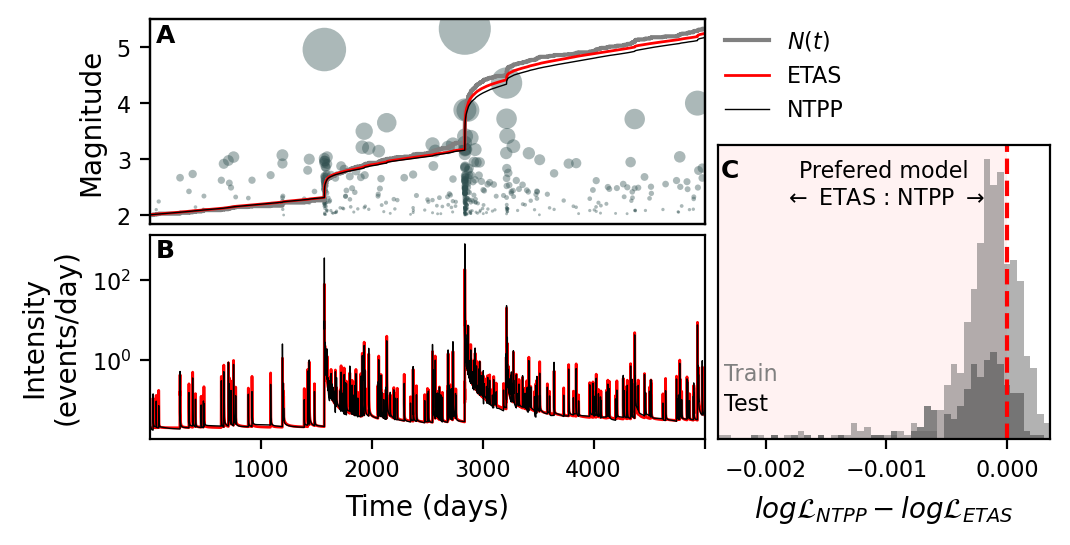

In [8]:
plt.rcParams['axes.grid'] = False
ETAS_color = 'red'; ETAS_lw = 1
ntpp_color = 'k'
real_color = 'grey'

# fig = plt.figure(constrained_layout=True,dpi=150,figsize=[6,5])
font = {'size'   : 8}
mpl.rc('font',**font)
mpl.rcParams['axes.labelsize'] = 10 
fig = plt.figure(figsize=(6, 3), dpi=200)
gs = fig.add_gridspec(
    2, 2,  
    width_ratios=(2,1.2), 
    height_ratios=(1,1),
    left=0.15, 
    right=0.90, 
    bottom=0.2, 
    top=0.9,
    wspace=0.03, 
    hspace=0.05
)
 
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:,1])
    
counting_process = (grid[:, None] > seq.arrival_times.cpu().numpy()).sum(-1)
counting_process = counting_process - counting_process[np.argmax(grid>t_nll_start)]

# Panel A
ax1.scatter(seq.arrival_times,seq.mag,s=(seq.mag-1)**4,alpha=0.4,c='darkslategrey',edgecolors='none')
ax1.set_xticks([])
ax1.set_ylabel('Magnitude')
ax1.margins(x=0)

ax1b = ax1.twinx()
ax1b.plot(grid, counting_process, c=real_color, label=r"$N(t)$")
ax1b.plot(grid, etas_compensator,c=ETAS_color,linewidth=ETAS_lw,label="ETAS")
# ax1b.axvspan(0,t_nll_start, facecolor='red', alpha=0.05, label='Burn-in')
ax1b.plot(grid, compensator, c=ntpp_color,linewidth=0.5, label="NTPP")
ax1b.get_yaxis().set_visible(False)
ax1b.legend(bbox_to_anchor=(1.0, 1.05),ncol=1,frameon=False)

# Panel B
ax2.plot(grid,etas_intensity,c=ETAS_color,linewidth=ETAS_lw)
ax2.plot(grid,intensity,c=ntpp_color,linewidth=0.5)
ax2.set_yscale('log')
ax2.set_xlabel('Time (days)')
ax2.margins(x=0)
ax2.set_ylabel('Intensity\n(events/day)')

x_ticks = ax2.xaxis.get_major_ticks()
x_ticks[-1].label1.set_visible(False)

# Panel C
xlim = np.quantile(llr["train"], [0.05,0.99])
ax3.axvline(0,c='r',ls='--')
ax3.axvspan(xlim[0],0, facecolor='red', alpha=0.05)
ax3.hist(llr["train"], 50,range=xlim,facecolor=[0.4, 0.4, 0.4], alpha=0.5,linewidth = 0.5, label='train')
ax3.hist(llr["test"],    50,range=xlim,facecolor=[0.4, 0.4, 0.4], alpha=0.8,linewidth = 0.5, label='test')
ax3.set_xlabel('$log\mathcal{L}_{NTPP} - log\mathcal{L}_{ETAS}$')
ax3.set_xlim(xlim)
ax3.get_yaxis().set_visible(False)
box = ax3.get_position()
shrink = 0.3
ax3.set_position([box.x0, box.y0,
                 box.width, box.height * (1-shrink)])
ax3.annotate('Train', (0.02, 0.2), xycoords='axes fraction',c='gray')
ax3.annotate('Test', (0.02, 0.1), xycoords='axes fraction',c='k')

ax3.annotate('Prefered model\n'+r'$\leftarrow$ ETAS : NTPP $\rightarrow$', (0.5,0.8),xycoords='axes fraction',c='k',ha='center')

for n, ax in enumerate([ax1,ax2,ax3]):
    ax.text(0.01, 0.89, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=9, weight='bold')

Fig. 2. NTPP performance on synthetic earthquake catalogs. (A-C) (A) Example of a synthetic earthquake catalog generated from an ETAS model in the test set. Events magnitudes and arrival times are indicated by the gray markers with the gray line tracking the cumulative number of events, N(t). The red (ETAS) and black (NTPP) lines indicate the modeled number of events with the corresponding conditional intensity functions in  (B). (C) Comparison of the training and test set log-likelihood (log L) as a measure of goodness of fit of these models. For any particular catalog LNTPP-LETAS greater than zero implies that the NTPP performed better than the ETAS model (and vice versa). In most cases, the NTPP log L  approaches the ETAS model.